<a href="https://colab.research.google.com/github/LorenaGiVa/Caso---Marketing/blob/main/c_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact ## para análisis interactivo
from sklearn import neighbors ### basado en contenido un solo producto consumido
import joblib

In [2]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162991 sha256=23fff377fbbb8bc5502eb0bf4c3be0402ec716741fd8d0e0bdf5af5026f16254
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## crear copia de db_movies datos originales, nombrarla movies2 y procesar movies2
conn = sql.connect('/content/drive/MyDrive/Caso marketing analítica/data/db_movies2.db') ### crear cuando no existe el nombre de cd y para conectarse cuando sí existe.
cur = conn.cursor()

In [6]:
### para ver las tablas que hay en la base de datos
cur.execute("select name from sqlite_master where type='table' ")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('full_ratings',),
 ('full_ratings_sin_dup',),
 ('reco',)]

In [7]:
df = pd.read_sql("SELECT * FROM full_ratings", conn)
df

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995.0,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995.0,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995.0,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995.0,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995.0,2000-07-30
...,...,...,...,...,...,...,...,...
70524,609,892,3.0,Twelfth Night (1996),Comedy|Drama|Romance,Twelfth Night (1996),1996.0,1996-11-05
70525,609,1056,3.0,Jude (1996),Drama,Jude (1996),1996.0,1996-11-05
70526,609,1059,3.0,William Shakespeare's Romeo + Juliet (1996),Drama|Romance,William Shakespeare's Romeo + Juliet (1996),1996.0,1996-11-05
70527,609,1150,4.0,"Return of Martin Guerre, The (Retour de Martin...",Drama,"Return of Martin Guerre, The (Retour de Martin...",1982.0,1996-11-05


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70529 entries, 0 to 70528
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            70529 non-null  int64  
 1   movie_id           70529 non-null  int64  
 2   rating             70529 non-null  float64
 3   movie_title        70529 non-null  object 
 4   movie_genres       70529 non-null  object 
 5   movie_clean_title  70529 non-null  object 
 6   movie_year         70518 non-null  float64
 7   fecha_nueva        70529 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.3+ MB


In [9]:
# Filtrar las filas donde la columna "movie_year" tenga valores nulos
nulos = df[df['movie_year'].isnull()]
nulos

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
8444,62,176601,5.0,Black Mirror,(no genres listed),Black Mirror,NaN,2018-05-08
15194,111,171631,1.0,Maria Bamford: Old Baby,(no genres listed),Maria Bamford: Old Baby,NaN,2018-01-31
15196,111,171891,3.5,Generation Iron 2,(no genres listed),Generation Iron 2,NaN,2018-01-31
25473,209,140956,3.5,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN,2018-04-23
25524,210,40697,4.0,Babylon 5,Sci-Fi,Babylon 5,NaN,2018-05-25
36779,305,140956,4.5,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN,2018-07-31
36897,306,149334,3.0,Nocturnal Animals,Drama|Thriller,Nocturnal Animals,NaN,2018-02-11
53509,462,162414,5.0,Moonlight,Drama,Moonlight,NaN,2016-11-07
59298,514,140956,3.0,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN,2018-08-11
61233,528,40697,0.5,Babylon 5,Sci-Fi,Babylon 5,NaN,2014-02-07


In [10]:
# Definir un diccionario de títulos de películas y sus años correspondientes
nuevos_anios = {
    'Babylon 5': 1994,
    'Ready Player One': 2018,
    'Black Mirror': 2018,
    'Maria Bamford: Old Baby': 2017,
    'Generation Iron 2': 2017,
    'Nocturnal Animals': 2016,
    'Moonlight': 2016,
    'Paterson': 2016
}

# Iterar sobre el diccionario y actualizar los años correspondientes en el DataFrame
for titulo, anio in nuevos_anios.items():
    df.loc[df['movie_title'] == titulo, 'movie_year'] = anio

Se imputaron los datos nulos

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70529 entries, 0 to 70528
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            70529 non-null  int64  
 1   movie_id           70529 non-null  int64  
 2   rating             70529 non-null  float64
 3   movie_title        70529 non-null  object 
 4   movie_genres       70529 non-null  object 
 5   movie_clean_title  70529 non-null  object 
 6   movie_year         70529 non-null  float64
 7   fecha_nueva        70529 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.3+ MB


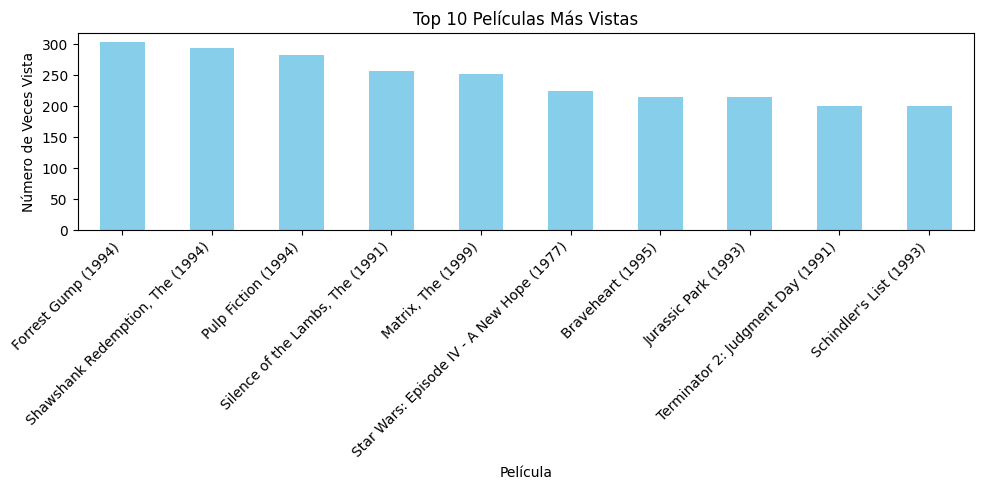

In [12]:
import matplotlib.pyplot as plt

# Agrupar por el título de la película y contar el número de ocurrencias
movie_views = df.groupby('movie_title')['user_id'].count().sort_values(ascending=False)

# Graficar el número de vistas por película
plt.figure(figsize=(10, 5))
movie_views.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Películas Más Vistas')
plt.xlabel('Película')
plt.ylabel('Número de Veces Vista')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Sistemas basados en popularidad

In [13]:
## peliculas vistas por más de 20 personas
pd.read_sql("""SELECT movie_title,
                avg(rating) as avg_rat,
                count(*) as movie_num
                FROM full_ratings
                WHERE rating <> 0
                GROUP BY movie_title
                HAVING count(*) >= 20
                ORDER BY avg_rat DESC, movie_num DESC
                LIMIT 10""", conn)

,movie_title,avg_rat,movie_num
0,"Shawshank Redemption, The (1994)",4.442177,294
1,"Manchurian Candidate, The (1962)",4.434783,23
2,Raging Bull (1980),4.403846,26
3,Hoop Dreams (1994),4.400000,25
4,Rosemary's Baby (1968),4.363636,22
5,Lawrence of Arabia (1962),4.319444,36
6,Cinema Paradiso (Nuovo cinema Paradiso) (1989),4.307692,26
7,In the Name of the Father (1993),4.300000,20
8,Cool Hand Luke (1967),4.287234,47
9,"Philadelphia Story, The (1940)",4.282609,23


In [14]:
#### los mejores calificados por año publicacion ###
pd.read_sql("""SELECT Año, movie_title, num_vistas
                FROM (
                    SELECT
                        strftime('%Y', fecha_nueva) AS Año,
                        movie_title,
                        ROW_NUMBER() OVER(PARTITION BY strftime('%Y', fecha_nueva) ORDER BY COUNT(*) DESC) AS row_num,
                        MAX(COUNT(*)) OVER(PARTITION BY strftime('%Y', fecha_nueva)) AS num_vistas
                    FROM full_ratings
                    GROUP BY strftime('%Y', fecha_nueva), movie_title) AS subquery
                WHERE row_num = 1
                ORDER BY Año;""", conn)

,Año,movie_title,num_vistas
0,1996,Batman (1989),83
1,1997,Independence Day (a.k.a. ID4) (1996),27
2,1998,Air Force One (1997),6
3,1999,Saving Private Ryan (1998),15
4,2000,American Beauty (1999),27
5,2001,Star Wars: Episode IV - A New Hope (1977),13
6,2002,"Silence of the Lambs, The (1991)",11
7,2003,"Lord of the Rings: The Two Towers, The (2002)",14
8,2004,Austin Powers: The Spy Who Shagged Me (1999),9
9,2005,"Sixth Sense, The (1999)",14


## Sistema de recomendación basado en contenido

In [15]:
df.head()

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995.0,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995.0,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995.0,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995.0,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995.0,2000-07-30


In [16]:
unique_genres = set()
for genres in df['movie_genres'].str.split('|'):
    unique_genres.update(genres)

# Contar la cantidad de géneros únicos
num_unique_genres = len(unique_genres)
print("Número de géneros diferentes:", num_unique_genres)

# Imprimir los géneros diferentes
print("Géneros diferentes:")
for genre in unique_genres:
    print(genre)

Número de géneros diferentes: 20
Géneros diferentes:
Musical
Crime
Documentary
IMAX
Sci-Fi
Thriller
War
Horror
Comedy
Western
Fantasy
Adventure
Film-Noir
Drama
(no genres listed)
Action
Animation
Children
Mystery
Romance


In [17]:
# Ajustar la configuración de visualización para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [18]:
df2 = df.copy()
# Convertir la variable de género en una lista de géneros para cada película
df2['movie_genres_list'] = df2['movie_genres'].str.split('|')

# Obtener todas las categorías únicas de géneros
unique_genres = set()
for genres_list in df2['movie_genres_list']:
    unique_genres.update(genres_list)

# Convertir la lista de géneros en variables dummy y agregarlas al DataFrame original
for genre in unique_genres:
    df2[genre] = df2['movie_genres_list'].apply(lambda x: 1 if genre in x else 0)

# Eliminar la columna temporal 'movie_genres_list'
df2.drop(columns=['movie_genres_list'], inplace=True)

# Mostrar las primeras filas del DataFrame resultante
df2.head()

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva,Musical,Crime,Documentary,IMAX,Sci-Fi,Thriller,War,Horror,Comedy,Western,Fantasy,Adventure,Film-Noir,Drama,(no genres listed),Action,Animation,Children,Mystery,Romance
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995.0,2000-07-30,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995.0,2000-07-30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995.0,2000-07-30,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995.0,2000-07-30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995.0,2000-07-30,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
# Eliminar las columnas del DataFrame
peliculas = df2.drop(columns=['user_id', 'movie_id', 'rating', 'movie_title', 'movie_genres', 'fecha_nueva']).copy()
peliculas.reset_index(drop=True, inplace=True)
peliculas['movie_year'] = peliculas['movie_year'].astype(int)
# Eliminar duplicados basados en la columna 'movie_clean_title'
peliculas = peliculas.drop_duplicates(subset=['movie_clean_title'])
# escalar el año de publicacion
sc = MinMaxScaler()
peliculas.loc[:, "movie_year"] = sc.fit_transform(peliculas[['movie_year']])
# Reiniciar el índice
peliculas.reset_index(drop=True, inplace=True)

peliculas

,movie_clean_title,movie_year,Musical,Crime,Documentary,IMAX,Sci-Fi,Thriller,War,Horror,Comedy,Western,Fantasy,Adventure,Film-Noir,Drama,(no genres listed),Action,Animation,Children,Mystery,Romance
0,Toy Story (1995),0.988563,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0
1,Grumpier Old Men (1995),0.988563,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,Heat (1995),0.988563,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Seven (a.k.a. Se7en) (1995),0.988563,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,"Usual Suspects, The (1995)",0.988563,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,Cirque du Freak: The Vampire's Assistant (2009),0.995525,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0
7168,Alice (2009),0.995525,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
7169,Fluke (1995),0.988563,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
7170,Assassination (1987),0.984585,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [20]:
# dummies
dummies = peliculas.drop(columns=['movie_clean_title'])
dummies

,movie_year,Musical,Crime,Documentary,IMAX,Sci-Fi,Thriller,War,Horror,Comedy,Western,Fantasy,Adventure,Film-Noir,Drama,(no genres listed),Action,Animation,Children,Mystery,Romance
0,0.988563,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0
1,0.988563,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0.988563,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.988563,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.988563,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,0.995525,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0
7168,0.995525,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
7169,0.988563,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
7170,0.984585,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [21]:
##### ### entrenar modelo #####
## el coseno de un angulo entre dos vectores es 1 cuando son perpendiculares y 0 cuando son paralelos(indicando que son muy similar)
model = neighbors.NearestNeighbors(n_neighbors = 6, metric='cosine')
model.fit(dummies)
dist, idlist = model.kneighbors(dummies)
distancias = pd.DataFrame(dist) ## devuelve un ranking de la distancias más cercanas para cada fila (pelicula)
id_list = pd.DataFrame(idlist) ## para saber esas distancias a que item corresponde

In [22]:
def MovieRecommender(movie_name=list(peliculas['movie_clean_title'].value_counts().index)):
    pelicula_list_name = []
    pelicula_id = peliculas[peliculas['movie_clean_title'] == movie_name].index
    pelicula_id = pelicula_id[0]
    # Obtener los vecinos más cercanos excluyendo la propia película
    neighbor_ids = [newid for newid in idlist[pelicula_id] if newid != pelicula_id]
    # Obtener los nombres de las películas vecinas
    for newid in neighbor_ids:
        pelicula_list_name.append(peliculas.loc[newid].movie_clean_title)
    recomendaciones = pd.DataFrame(pelicula_list_name, columns=['Peliculas Recomendadas'])
    return recomendaciones

print(interact(MovieRecommender))

interactive(children=(Dropdown(description='movie_name', options=('Toy Story (1995)', "They Shoot Horses, Don'…

<function MovieRecommender at 0x7c4b64b54160>


## Sistema de recomendación basado en el contenido de cada usuario

In [23]:
# Eliminar las columnas del DataFrame
movies = df.drop(columns=['user_id','rating', 'movie_title', 'fecha_nueva']).copy()
movies['movie_year'] = movies['movie_year'].astype(int)
# Eliminar duplicados basados en la columna 'movie_clean_title'
movies = movies.drop_duplicates(subset=['movie_clean_title'])
movies.reset_index(drop=True, inplace=True)

In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   movie_id           7172 non-null   int64 
 1   movie_genres       7172 non-null   object
 2   movie_clean_title  7172 non-null   object
 3   movie_year         7172 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 224.2+ KB


In [25]:
#### seleccionar usuario para recomendaciones ####
usuarios = pd.read_sql('select distinct (user_id) as user_id from ratings_final',conn)

In [26]:
dummies2 = dummies.copy()

In [27]:
def recomendar(user_id=list(usuarios['user_id'].value_counts().index)):

    ###seleccionar solo los ratings del usuario seleccionado
    ratings = pd.read_sql('select * from ratings_final where user_id=:user',conn, params={'user':user_id,})

    ###convertir ratings del usuario a array
    l_peliculas_s = ratings['movie_id'].to_numpy()

    ###agregar la columna de movieID de la pelicula a dummie para filtrar y mostrar nombre
    dummies2[['movie_id', 'movie_clean_title']] = movies[['movie_id', 'movie_clean_title']]

    ### filtrar libros calificados por el usuario
    peliculas_s = dummies2[dummies2['movie_id'].isin(l_peliculas_s)]

    ## eliminar columna nombre e isbn
    peliculas_s = peliculas_s.drop(columns=['movie_id','movie_clean_title'])
    peliculas_s["indice"] = 1

    ##centroide o perfil del usuario
    centroide = peliculas_s.groupby("indice").mean()

    ### filtrar lpeliculas no vistas
    peliculas_ns = dummies2[~dummies2['movie_id'].isin(l_peliculas_s)]

    ## eliminar clean_title y movie_id
    peliculas_ns = peliculas_ns.drop(columns=['movie_id','movie_clean_title'])

    ### entrenar modelo
    model = neighbors.NearestNeighbors(n_neighbors=10, metric='cosine')
    model.fit(peliculas_ns)
    dist, idlist = model.kneighbors(centroide)
    ids=idlist[0] ### queda en un array anidado, para sacarlo
    recomend_movies = movies.loc[ids][['movie_clean_title','movie_id']]
    vistas = movies[movies['movie_id'].isin(l_peliculas_s)][['movie_clean_title','movie_id']]
    return recomend_movies


In [28]:
print(interact(recomendar))

interactive(children=(Dropdown(description='user_id', options=(1, 417, 400, 401, 402, 403, 404, 405, 406, 407,…

<function recomendar at 0x7c4b64d03760>


# Sistema de recomendación de filtros colaborativos

In [29]:
df = pd.read_sql("SELECT * FROM full_ratings", conn)
df

,user_id,movie_id,rating,movie_title,movie_genres,movie_clean_title,movie_year,fecha_nueva
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995.0,2000-07-30
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men (1995),1995.0,2000-07-30
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,Heat (1995),1995.0,2000-07-30
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995.0,2000-07-30
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995.0,2000-07-30
...,...,...,...,...,...,...,...,...
70524,609,892,3.0,Twelfth Night (1996),Comedy|Drama|Romance,Twelfth Night (1996),1996.0,1996-11-05
70525,609,1056,3.0,Jude (1996),Drama,Jude (1996),1996.0,1996-11-05
70526,609,1059,3.0,William Shakespeare's Romeo + Juliet (1996),Drama|Romance,William Shakespeare's Romeo + Juliet (1996),1996.0,1996-11-05
70527,609,1150,4.0,"Return of Martin Guerre, The (Retour de Martin...",Drama,"Return of Martin Guerre, The (Retour de Martin...",1982.0,1996-11-05


In [30]:
### datos originales en pandas
## knn solo sirve para calificaciones explicitas
ratings = pd.read_sql('select * from full_ratings where rating>0', conn)

In [31]:
####los datos deben ser leidos en un formato espacial para surprise
reader = Reader(rating_scale=(0, 10)) ### la escala de la calificación
###las columnas deben estar en orden estándar: user item rating
data   = Dataset.load_from_df(ratings[['user_id',	'movie_id',	'rating']], reader)

In [32]:
##### Hacer una lista con los modelos
models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()]
results = {}

In [33]:
#### for para probar varios modelos ##########
model=models[1]
for model in models:

    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)

    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result

performance_df = pd.DataFrame.from_dict(results).T
performance_df.sort_values(by='RMSE')

,MAE,RMSE,fit_time,test_time
knns.KNNBaseline,0.698457,0.918132,0.324948,2.248862
knns.KNNWithMeans,0.711679,0.934523,0.288089,3.657641
knns.KNNWithZScore,0.706924,0.934912,0.174248,1.556886
knns.KNNBasic,0.751746,0.987857,0.238855,2.983365


Se escoge el knn Baseline ya que tiene un menor valor en el RMSE y en el MAE, además el tiempo de evaluación también es menor que el de los otros modelos.

In [34]:
# se escoge el mejor knn Baseline
# Afinamiento de hiperparámentros
param_grid = { 'sim_options' : {'name': ['msd','cosine'], \
                                'min_support': [5,2], \
                                'user_based': [False, True]}
             }

In [35]:
gridsearchKNNWithBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], \
                                      cv=5, n_jobs=-1)

gridsearchKNNWithBaseline.fit(data)

In [36]:
gridsearchKNNWithBaseline.best_params["rmse"]

{'sim_options': {'name': 'msd', 'min_support': 2, 'user_based': False}}

In [37]:
gridsearchKNNWithBaseline.best_score["rmse"]

0.8964508611397533

In [38]:
gs_model=gridsearchKNNWithBaseline.best_estimator['rmse'] ### mejor estimador de gridsearch

In [39]:
################# Entrenar con todos los datos y Realizar predicciones con el modelo afinado

trainset = data.build_full_trainset() ### esta función convierte todos los datos en entrnamiento, las funciones anteriores dividen  en entrenamiento y evaluación
model=gs_model.fit(trainset) ## se reentrena sobre todos los datos posibles (sin dividir)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [40]:
predset = trainset.build_anti_testset() ### crea una tabla con todos los usuarios y las peliculas que no han visto
#### en la columna de rating pone el promedio de todos los rating, en caso de que no pueda calcularlo para un item-usuario
len(predset)

4120255

In [41]:
predictions = gs_model.test(predset) ### función muy pesada, hace las predicciones de rating para todos los libros que no hay leido un usuario
### la funcion test recibe un test set constriuido con build_test method, o el que genera crosvalidate

In [42]:
predictions_df = pd.DataFrame(predictions) ### esta tabla se puede llevar a una base donde estarán todas las predicciones

In [43]:
predictions_df.shape

(4120255, 5)

In [44]:
predictions_df.head()

,uid,iid,r_ui,est,details
0,1,318,3.606687,5.215185,"{'actual_k': 40, 'was_impossible': False}"
1,1,1704,3.606687,4.983260,"{'actual_k': 40, 'was_impossible': False}"
2,1,6874,3.606687,4.758713,"{'actual_k': 40, 'was_impossible': False}"
3,1,8798,3.606687,4.506234,"{'actual_k': 40, 'was_impossible': False}"
4,1,46970,3.606687,3.926563,"{'actual_k': 40, 'was_impossible': False}"


In [45]:
predictions_df['r_ui'].unique() ### promedio de ratings

array([3.60668661])

In [46]:
predictions_df.sort_values(by='est',ascending=False).head()

,uid,iid,r_ui,est,details
363727,53,1178,3.606687,5.966679,"{'actual_k': 1, 'was_impossible': False}"
361342,53,62336,3.606687,5.779338,"{'actual_k': 1, 'was_impossible': False}"
360970,53,3213,3.606687,5.774930,"{'actual_k': 2, 'was_impossible': False}"
1644813,240,4079,3.606687,5.770685,"{'actual_k': 1, 'was_impossible': False}"
383252,56,4079,3.606687,5.770685,"{'actual_k': 1, 'was_impossible': False}"


In [47]:
movies = movies.drop(columns=['movie_genres'])
movies

,movie_id,movie_clean_title,movie_year
0,1,Toy Story (1995),1995
1,3,Grumpier Old Men (1995),1995
2,6,Heat (1995),1995
3,47,Seven (a.k.a. Se7en) (1995),1995
4,50,"Usual Suspects, The (1995)",1995
...,...,...,...
7167,72165,Cirque du Freak: The Vampire's Assistant (2009),2009
7168,72982,Alice (2009),2009
7169,241,Fluke (1995),1995
7170,2737,Assassination (1987),1987


In [56]:
def recomendaciones(user_id, movies_df, n_recomend=10):
    predictions_userID = predictions_df[predictions_df['uid'] == user_id].\
                    sort_values(by="est", ascending=False).head(n_recomend)

    recomendados = predictions_userID[['iid', 'est']]

    # Unir las recomendaciones con la información de las películas
    recomendados_con_info = pd.merge(recomendados, movies_df,
                                     left_on='iid', right_on='movie_id', how='left')

    return recomendados_con_info

# Llamar a la función recomendaciones pasando la tabla movies como parámetro
recomendaciones(user_id=609, movies_df=movies, n_recomend=10)

,iid,est,movie_id,movie_clean_title,movie_year
0,1340,4.018948,1340,"Bride of Frankenstein, The (Bride of Frankenst...",1935
1,70305,3.983820,70305,Race to Witch Mountain (2009),2009
2,2789,3.898677,2789,Damien: Omen II (1978),1978
3,750,3.870386,750,Dr. Strangelove or: How I Learned to Stop Worr...,1964
4,2790,3.852282,2790,"Final Conflict, The (a.k.a. Omen III: The Fina...",1981
5,2868,3.852282,2868,Fright Night Part II (1988),1988
6,1204,3.828131,1204,Lawrence of Arabia (1962),1962
7,2959,3.824811,2959,Fight Club (1999),1999
8,1193,3.819530,1193,One Flew Over the Cuckoo's Nest (1975),1975
9,50,3.818184,50,"Usual Suspects, The (1995)",1995
